# Bayesian Linear Regression Techniques

The ‘Energy Efficiency’ dataset supplied by the University of Oxford consists of 8 input variables
`x1`, `x2`, . . . , `x8` which are predictors for the ‘Heating Load’(`y`) a house can maintain. Predictor
variables are the architectural attributes of the house including:
1. Relative Compactness
2. Surface Area
3. Wall Area
4. Roof Area
5. Overall Height
6. Orientation
7. Glazing Area
8. Glazing Area Distribution

In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy import stats
import hmc_Lab as hmc
import warnings

# Step 1 : Exploratory analysis 

In [2]:
# Data feed
X_train_df = pd.read_csv("data/ee-train.csv", usecols=lambda column: column != 'Heating Load')
X_train = X_train_df.values
y_train_df  = pd.read_csv("data/ee-train.csv", usecols=['Heating Load'])['Heating Load']
y_train = y_train_df.values

X_test_df = pd.read_csv("data/ee-test.csv", usecols=lambda column: column != 'Heating Load')
X_test = X_test_df.values
y_test_df  = pd.read_csv("data/ee-test.csv", usecols=['Heating Load'])['Heating Load']
y_test = y_test_df.values


Standardize the data 

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Standardize the data
# X_train
X_train_constant = X_train[:, 0].reshape(-1, 1)
X_train_ = X_train[:, 1:]
scaler.fit(X_train_)
X_train_scaled = scaler.transform(X_train_)
X_train = np.hstack((X_train_constant.reshape(-1, 1), X_train_scaled))

# X_test
X_test_constant = X_test[:, 0].reshape(-1, 1)
X_test_ = X_test[:, 1:]
X_test_scaled = scaler.transform(X_test_)
X_test = np.hstack((X_test_constant.reshape(-1, 1), X_test_scaled))

Visualize the predictor variables relationship with Housing Load

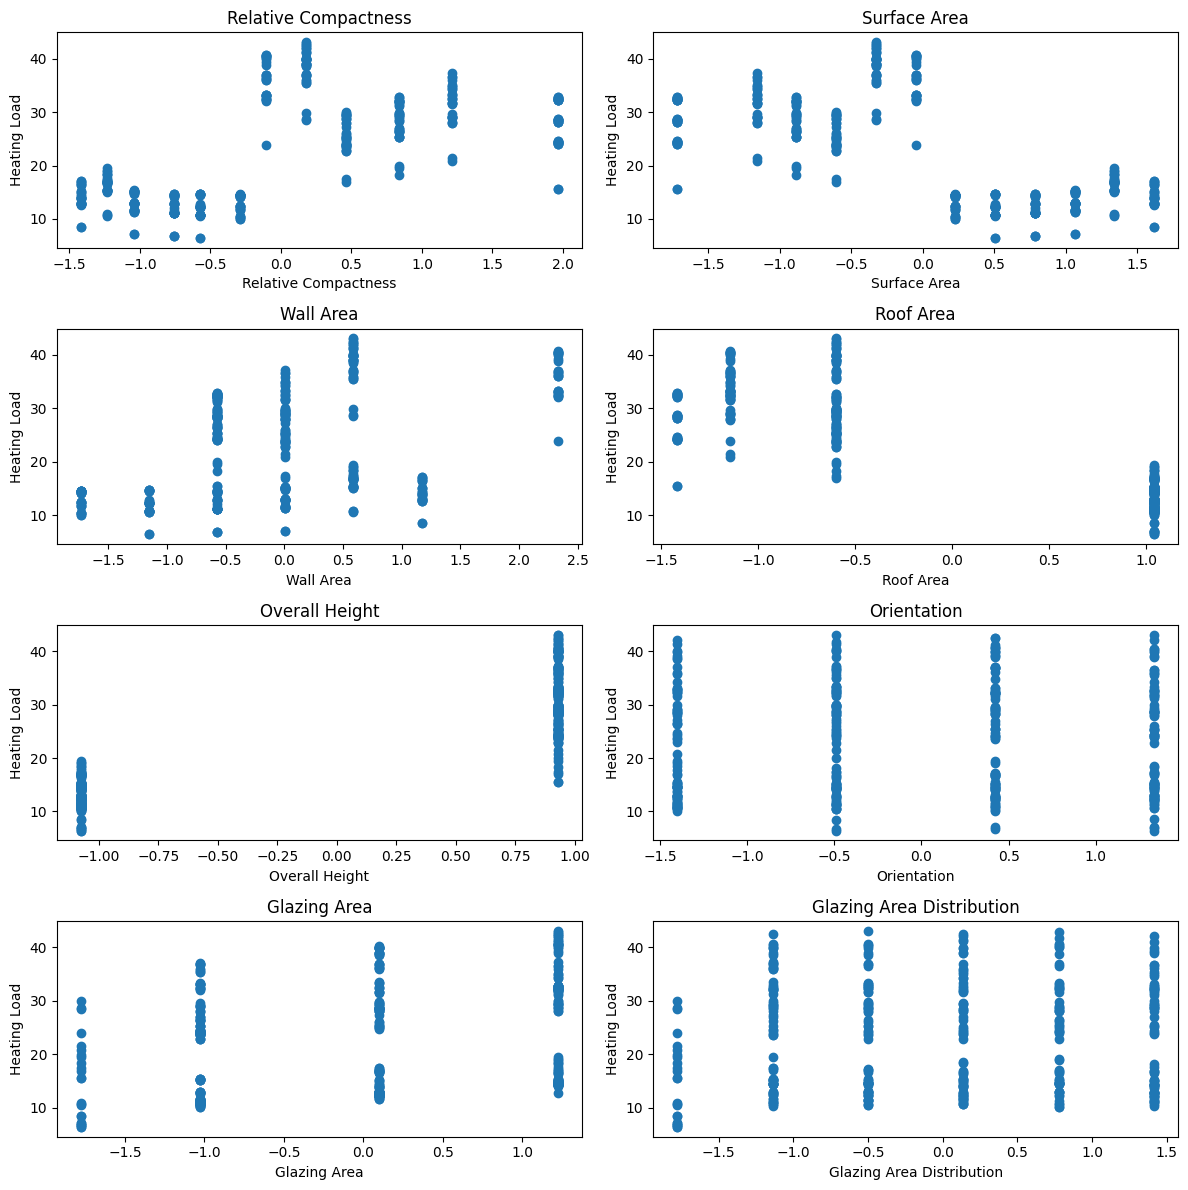

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))

for i in range(1, X_train.shape[1]):
    row = (i - 1) // 2
    col = (i - 1) % 2
    axs[row, col].scatter(X_train[:, i], y_train)
    axs[row, col].set_title(X_train_df.columns[i])
    axs[row, col].set_xlabel(X_train_df.columns[i])
    axs[row, col].set_ylabel("Heating Load")

fig.tight_layout()
plt.show()

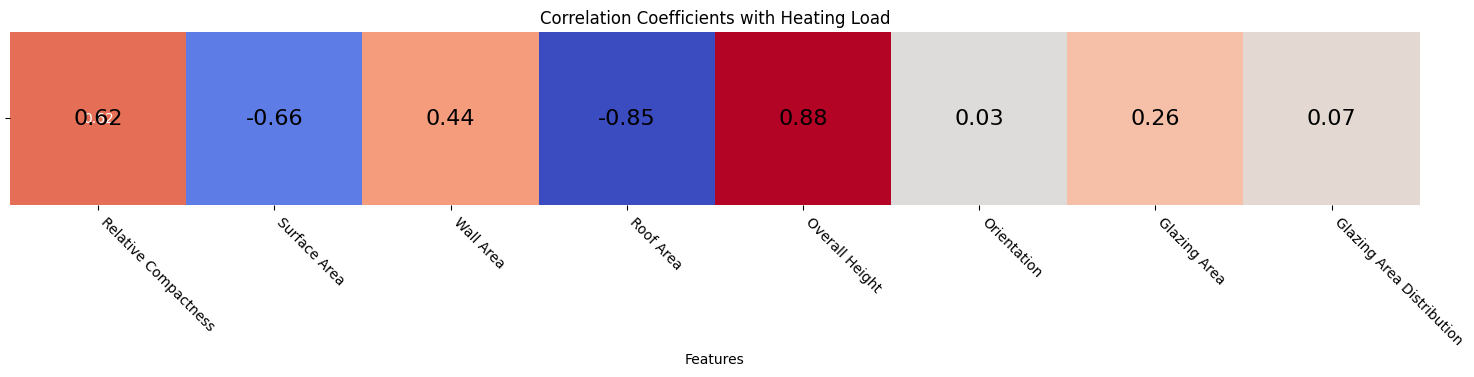

<Figure size 640x480 with 0 Axes>

In [5]:
import seaborn as sns

data = np.column_stack([X_train[:, 1:], y_train])
corr_matrix = np.corrcoef(data, rowvar=False)
corr_matrix_transpose = np.transpose(corr_matrix[:-1, -1:])

# Prepare custom annotation labels, handling NaNs
annot_labels = []
for val in corr_matrix_transpose.flatten():
    if np.isnan(val):
        annot_labels.append("")  # Display NaN as an empty string
    else:
        annot_labels.append(f"{val:.2f}")
annot_labels_array = np.array(annot_labels).reshape(corr_matrix_transpose.shape)

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
# Corrected line: Added fmt=''
sns.heatmap(corr_matrix_transpose, cmap='coolwarm', annot=annot_labels_array, cbar=False, fmt='',
            annot_kws={'size': 10},
            yticklabels=[''])
plt.title('Correlation Coefficients with Heating Load')
plt.xlabel('Features')

tick_labels = X_train_df.columns[1:]
ax.set_xticklabels(tick_labels, rotation=-45, ha='left')

for i in range(corr_matrix_transpose.shape[0]): 
    for j in range(corr_matrix_transpose.shape[1]): # Iterate through features/columns
        val = corr_matrix_transpose[i, j]
        text_label = ""
        if not np.isnan(val):
            text_label = f"{val:.2f}"
        ax.text(j + 0.5, i + 0.5, text_label, # j+0.5 and i+0.5 for cell center
                ha='center', va='center', color='black', fontsize=16)

plt.tight_layout()
plt.subplots_adjust(bottom=0.3)
plt.show()

plt.tight_layout()
plt.subplots_adjust(bottom=0.3)
plt.show()

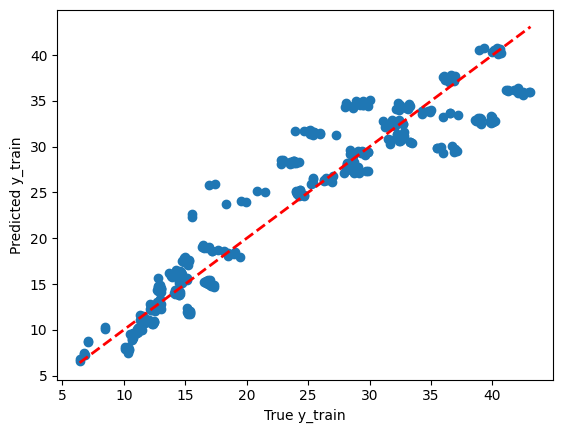

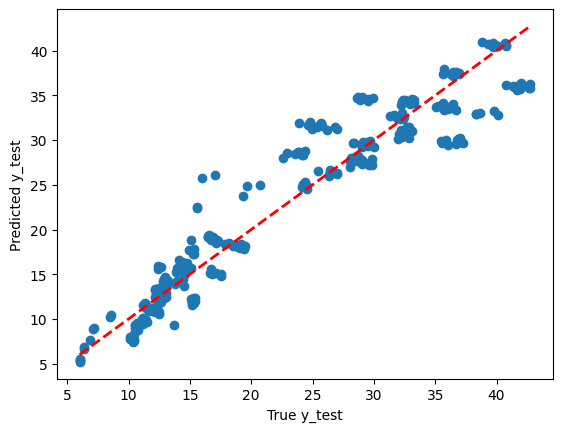

RMSE for y_train: 3.0116
RMSE for y_test: 2.8436
MAE for y_train: 2.1307
MAE for y_test: 2.0690


In [6]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(0)
# Compute the least squares solution
w = np.linalg.lstsq(X_train, y_train, rcond=None)[0]
# Predict y_train using the computed coefficients
y_train_pred = np.dot(X_train, w)
plt.scatter(y_train, y_train_pred)
plt.xlabel('True y_train')
plt.ylabel('Predicted y_train')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', linewidth=2)  # Line of best fit
plt.show()

# Predict y_test using the computed coefficients
y_test_pred = np.dot(X_test, w)
plt.scatter(y_test, y_test_pred)
plt.xlabel('True y_test')
plt.ylabel('Predicted y_test')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)  # Line of best fit
plt.show()

#Train RMSE & MAE
RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)

# Test RMSE & MAE
RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)

print('RMSE for y_train: {:.4f}'.format(RMSE_train))
print('RMSE for y_test: {:.4f}'.format(RMSE_test))
print('MAE for y_train: {:.4f}'.format(mae_train))
print('MAE for y_test: {:.4f}'.format(mae_test))

In [7]:
# Check whether fixed variables are correctly defined ..
try:
    if not isinstance(X_train,np.ndarray):
        print('X_train should be an array')        
    if X_train.shape != (384,9):
        print('X_train is arranged in wrong shape')
except Exception as err:
    print('Error output:', err)
    
try:
    if not isinstance(y_train,np.ndarray):
        print('y_train should be an array')        
    if y_train.shape != (384,):
        print('y_train is arranged in wrong shape')
    if y_train.mean()<10:
        print('Do not apply any normalization technique to obtain `y_train`')
except Exception as err:
    print('Error output:', err)

#  Step 2 : Type-2 maximum likelihood

Precisions are defined as: $\alpha = 1 / \sigma_w^2$ and $ \beta = 1 / \sigma_{\epsilon}^2 $

Assume priors of $\alpha$ and $\beta$ follow flat Uniform distributions, please derive a likelihood function $(y|\alpha, \beta)$ (`compute_log_marginal`) to compute the *log-ikelihood* for the Bayesian linear regression problem using $X$ and hyperparameters $\alpha$ and $\beta$. 

Find the most probable hyperparameters to maximise the likelihood with respect to the hyperparameters.


In [8]:
## Compute log-likelihood
def compute_posterior(X, y, alpha, beta):
    M = X.shape[1]
    H = beta*(X.T @ X) + alpha*np.eye(M)
    SIGMA = np.linalg.inv(H)
    Mu = beta*(SIGMA @ (X.T @ y))
    
    return Mu, SIGMA

def compute_log_marginal(X, y, alph, beta):
    # BML Coursework 2 - Log Marginal Calculation
    N, M = X.shape
    Mu, SIGMA = compute_posterior(X, y, alph, beta)
    logML = -N * np.log(2 * np.pi)
    sgn, logdet = np.linalg.slogdet(SIGMA)
    if sgn < 0:
        print("Error with alpha={0}, s2={1}".format(alph, beta))
    logML += logdet + N*np.log(beta) + M*np.log(alph)
    logML -= beta * (y.T @ (y - X @ Mu))
    lgp = logML / 2.0
    return lgp

Compute log-evidence (marginal likelihood) `log_prob_y` and plot the 'contourf' of the log-posterior distribution.

In [9]:
v = np.linspace(-5,0,100)

a = np.exp(v)
B = np.exp(v)

log_a = np.log(a)
log_B = np.log(B)

log_prob_y = np.zeros([100,100])
prob_y = np.zeros([100,100])

# #find p(a,B|y) for values of a and B
for i in range(len(a)):
    for j in range(len(B)):
        log_prob_y[j,i] = compute_log_marginal(X_train, y_train, a[i], B[j])

# Check whether your variables are correctly defined ..
try:
    if not isinstance(log_prob_y,np.ndarray):
        print('log_prob_y should be an array')        
    if log_prob_y.shape != (100,100):
        print('log_prob_y is arranged in a wrong shape')
except Exception as err:
    print('Error output:', err)

Find the most probable values of the parameters $\alpha$ and $\beta$ and the corresponding log-likelihood value.

In [10]:
#find index of maximum a and r
max_ind = np.unravel_index(np.argmax(log_prob_y, axis=None), log_prob_y.shape)
max_a = np.exp(log_a[max_ind[1]])
max_B = np.exp(log_B[max_ind[0]])
max_log_prob = compute_log_marginal(X_train, y_train, max_a, max_B)

print("Most probable a: {:.4f}".format(max_a))
print("Most probable B: {:.4f}".format(max_B))
print("Log_p given a & B: {:.4f}".format(max_log_prob))

Most probable a: 0.0117
Most probable B: 0.1084
Log_p given a & B: -1001.4576


Visualisation using `plt.contourf` for the posterior distribution and indicate the most probable value (with a highlighted marker) in the graph.

<function matplotlib.pyplot.show(close=None, block=None)>

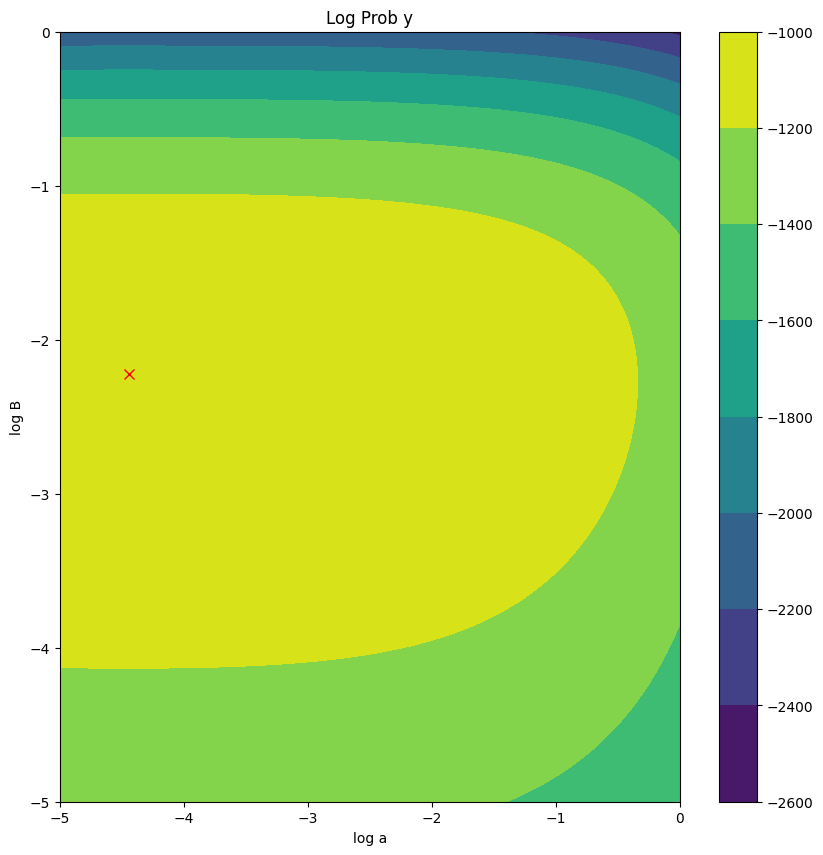

In [11]:
#plot log_prob_y
fig,ax=plt.subplots(1,1, figsize=(10,10))
cp = ax.contourf(log_a, log_B, log_prob_y)
fig.colorbar(cp)
ax.plot(np.log(max_a), np.log(max_B), 'rx', markersize=7) 
ax.set_title('Log Prob y')
ax.set_xlabel('log a')
ax.set_ylabel('log B')
plt.show

Function `compute_posterior(X, y, alph, beta)` to compute the posterior mean $\mathbf{\mu}$ (`Mu`) and covariance $\mathbf{\Sigma}$ (`SIGMA`) for the Bayesian linear regression model, and return `Mu` and `SIGMA` for the posterior in the np.array format. 

In [12]:
def compute_posterior(X, y, alph, beta):
    M = X.shape[1]

    H = beta*(X.T @ X) + alph*np.eye(M)

    SIGMA = np.linalg.inv(H)

    Mu = beta*(SIGMA @ (X.T @ y))
    
    return Mu, SIGMA


Calculate the predicted weights and print out the corresponding RMSE for training and test sets.

In [13]:
def w_fit(X, y, alph, beta):
    Mu, SIGMA = compute_posterior(X, y, alph, beta)
    w = Mu
    return w, SIGMA

#RMSE & MAE
T = y_train.shape[0]
mu_n, SIGMA = w_fit(X_train, y_train, max_a, max_B)

pred_train = np.dot(X_train,mu_n)
rmse_train = np.sqrt(np.sum(np.square(y_train-pred_train))/T)
mae_train = mean_absolute_error(y_train, pred_train )


pred_test = np.dot(X_test,mu_n)
rmse_test = np.sqrt(np.sum(np.square(y_test-pred_test))/T)
mae_test = mean_absolute_error(y_test, pred_test)


print("RMSE for training set: {:.4f}".format(rmse_train))
print("RMSE for test set: {:.4f}".format(rmse_test))
print('MAE for y_train: {:.4f}'.format(mae_train))
print('MAE for y_test: {:.4f}'.format(mae_test))

RMSE for training set: 3.0117
RMSE for test set: 2.8434
MAE for y_train: 2.1302
MAE for y_test: 2.0668


# Step 3: Variational Inference

Variational Inference function `VI(X_train, Y_train)` which returns parameter estimates. 

`an`, `bn`, `cn`, `dn`: float

`mn_n`: np.array, shape = (9,),

`sig_n`: np.array, shape = (9,9),

where

`an` and `bn` are the hyper-parameters for $w\propto  N(w|0,\alpha)$,  $\alpha\propto Gamma(\alpha|a,b) $. 

`cn` and `dn` are the hyper-parameters for gaussian noise $N(0,\beta)$,  $\beta\propto Gamma(\beta|c,d) $.

`mn_n` and `sig_n` are the mean $\mathbf{\mu}$ and covariance $\mathbf{\Sigma}$ of the posterior distribution w.r.t. $w$ (in this step) for the Bayesian linear regression model.

In [14]:
def VI(X, y):
    np.random.seed(seed=1)
    #Hyper-parameters
    a0=1e-3
    b0=1e-3
    c0=1e-3
    d0=1e-3
    
    # Set-up
    N, M = X.shape
    max_iteration=1000
    tol=1e-4
    an = a0 + M / 2
    cn = c0 + N / 2
    bn, dn = b0, d0
    XX = X.T @ X
    Xy = X.T @ y
    L_check = -np.inf
    l_bound = np.zeros(max_iteration)
    #iterate through the algorithm
    for i in range(max_iteration):
        inv_sig = cn/dn * np.eye(M) + XX *(cn/dn)
        sin_n = np.linalg.inv(inv_sig)
        logdet_sig = -np.linalg.slogdet(inv_sig)[1]
        mu_n = (sin_n@Xy)*cn/dn

        # Alpha
        an = a0 + M / 2
        bn = b0 + (np.sum(mu_n**2) + np.trace(sin_n))/2

        # Beta
        cn = c0 + N / 2
        errors = np.sum(((X@mu_n) - y) ** 2)
        dn = d0 + (errors +  np.trace(XX @ sin_n))/2

        # ELBOW lower bound
        A = an - an * np.log(bn)
        B = 0.5 * logdet_sig - d0 * (cn / dn) + cn - cn* np.log(dn) + cn 
        L = -0.5 * ((cn / dn) * errors + np.sum(X @ (sin_n@X.T))) + A + B
        l_bound[i] = L

        if abs(L - L_check) < tol * abs(L_check) and i > 0 :
            break
        L_check = L

    return an, bn, cn, dn, mu_n, sin_n

Show the expectation of $\alpha$ and $\beta$ as `exp_alpha`, `exp_beta`. 


In [15]:
an, bn, cn, dn, mu_n, sig_n= VI(X_train, y_train)
exp_alpha = an/bn 
print("Expected alpha: {:.4f}".format(exp_alpha))
exp_beta = cn/dn
print("Expected beta: {:.4f}".format(exp_beta))
VI_log_prob = compute_log_marginal(X_train, y_train, exp_alpha, exp_beta)
print("Log_p given a & B: {}".format(VI_log_prob))

try:
    an,bn,cn,dn, mu_n, sig_n = VI(X_train, y_train)
except Exception as err:
    print('Error output:', err)


Expected alpha: 0.0139
Expected beta: 0.1076
Log_p given a & B: -1001.50385888091


In [16]:
# Check whether variables are correctly defined
try:
    if not isinstance(mu_n,np.ndarray):
        print('mu_n should be an array')        
    if mu_n.shape != (9,):
        print('mu_n is arranged in wrong shape')
except Exception as err:
    print('Error output:', err)
    
try:
    if not isinstance(sig_n,np.ndarray):
        print('sig_n should be an array')        
    if sig_n.shape != (9,9):
        print('sig_n is arranged in wrong shape')
except Exception as err:
    print('Error output:', err)
    
try:
    exp_alpha
    exp_beta
except Exception as err:
    print('Error output:', err)

Calculate the RMSE for training and test sets.

In [17]:
#RMSE 
T = y_train.shape[0]

#Train RMSE and MAE
pred_train = np.dot(X_train,mu_n)
rmse_train = np.sqrt(np.sum(np.square(y_train-pred_train))/T)
mae_train = mean_absolute_error(y_train, pred_train )


# Test RMSE and MAE
pred_test = np.dot(X_test,mu_n)
rmse_test = np.sqrt(np.sum(np.square(y_test-pred_test))/T)
mae_test = mean_absolute_error(y_test, pred_test)


print("RMSE for training set: {:.4f}".format(rmse_train))
print("RMSE for test set: {:.4f}".format(rmse_test))
print('MAE for y_train: {:.4f}'.format(mae_train))
print('MAE for y_test: {:.4f}'.format(mae_test))

RMSE for training set: 3.0177
RMSE for test set: 2.8485
MAE for y_train: 2.1339
MAE for y_test: 2.0616


Contour plot of data and $\alpha_{exp}$ and $\beta_{exp}$ from VI as well as $\alpha_{max}$ and $\beta_{max}$ from Type-II Method

<function matplotlib.pyplot.show(close=None, block=None)>

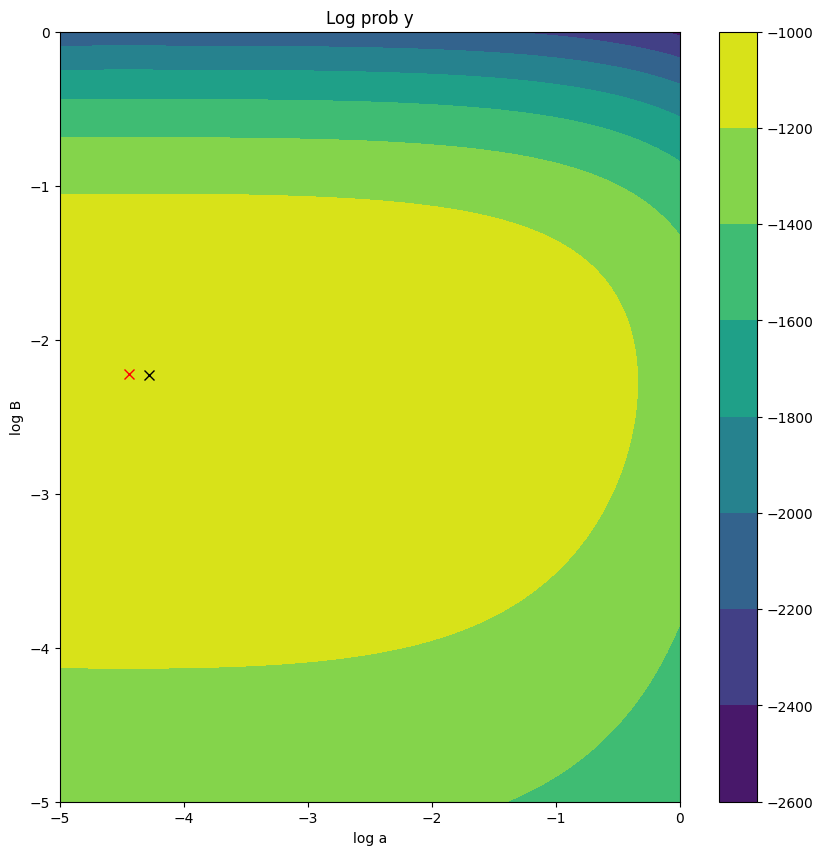

In [18]:
#plot log_prob_y
fig,ax=plt.subplots(1,1, figsize=(10,10))
cp = ax.contourf(log_a, log_B, log_prob_y)
fig.colorbar(cp)
ax.plot(np.log(max_a), np.log(max_B), 'rx', markersize=7)
ax.plot(np.log(exp_alpha), np.log(exp_beta), 'kx', markersize=7)
ax.set_title('Log prob y')
ax.set_xlabel('log a')
ax.set_ylabel('log B')
plt.show

# Step 4: Verify HMC on a standard 2D Gaussian example

## The "Distribution"

Hamiltonian Monte Carlo Method:

- `energy_func(x)`: the energy function, return negative log pdf value in float format
- `energy_grad(x)`: the gradient function returns a numpy array containing the partial derivatives of the energy function with respect to the parameters/hyper-parameters.
- `covar`: Covariance matrix for 2-dimensional gaussian. It is an numpy array with shape (2,2), e.g,  np.array([[1.0875,1],[1,1.0875]]) 

- `R`: the number of samples desired
- `L`: number of simulation steps; for this simple case, 20 is easily enough
- `eps`: simulation step length; set by trial-and-error to give approx. 90% acceptance
- `burn`: simply set to `R/10`
- `checkgrad`: set to true to test the consistency of `energy_func` and `energy_grad`



In [19]:
from scipy.stats import multivariate_normal

def energy_func(x, covar):
    neglgp = -multivariate_normal.logpdf(x, mean=None, cov=covar)
    return neglgp

def energy_grad(x, covar):
    g = np.empty(2) 
    cov_inv = np.linalg.inv(covar)
    delta = x - [0,0]
    g = np.matmul(cov_inv, delta)
    return g

## Visualising the Distribution
Before we run the sampler, let's visualise the distribution over an appropriate
grid of values.

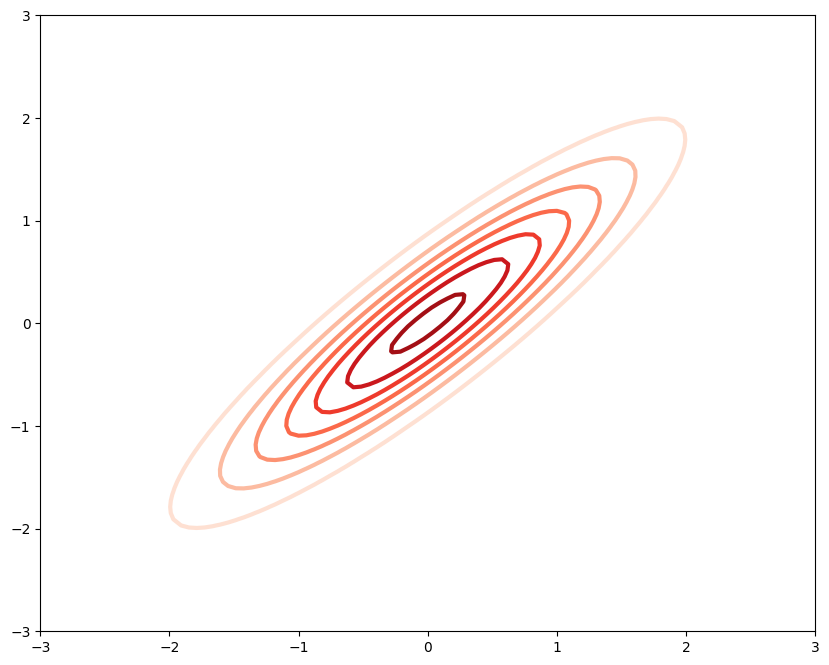

In [20]:
covar = np.array([[1,0.9],[0.9,1]]) 

f = 5  # The "frequency" argument for the energy, used here to demonstrate how to use "args"
# plotting features
fsz = (10,8)
gsz = 100
lim = 3

# Setup the mesh grid
gx = np.linspace(-lim, lim, gsz)
GX, GY = np.meshgrid(gx, gx)
Gsz = GX.size
G = np.hstack((GX.reshape((Gsz, 1)), GY.reshape((Gsz, 1))))

# Plot the figure
plt.figure(figsize=fsz)
P = np.asarray([np.exp(-energy_func(g, covar)) for g in G])
plt.contour(GX, GY, P.reshape((gsz, gsz)), cmap='Reds', linewidths=3, zorder=1);

In [21]:
try:
    if not isinstance(covar ,np.ndarray):
        print('covar  should be an array')        
    if covar .shape != (2,2):
        print('covar  is arranged in wrong shape')
except Exception as err:
    print('Error output:', err)

## Hyper-parameters

Please tune optimal hyper-parameters incluidng `R`, `L`, and `eps` in the cell below. 

|----------|  0% accepted [ 8 secs to go ]
|#---------| 91% accepted [ 7 secs to go ]
|##--------| 91% accepted [ 6 secs to go ]
|###-------| 91% accepted [ 5 secs to go ]
|####------| 91% accepted [ 4 secs to go ]
|#####-----| 91% accepted [ 4 secs to go ]
|######----| 91% accepted [ 3 secs to go ]
|#######---| 91% accepted [ 2 secs to go ]
|########--| 91% accepted [ 1 secs to go ]
|#########-| 91% accepted [ 1 secs to go ]
|##########| 91% accepted [ 0 secs to go ]
HMC: R=10000 / L=25 / eps=0.375 / Accept=91.1%


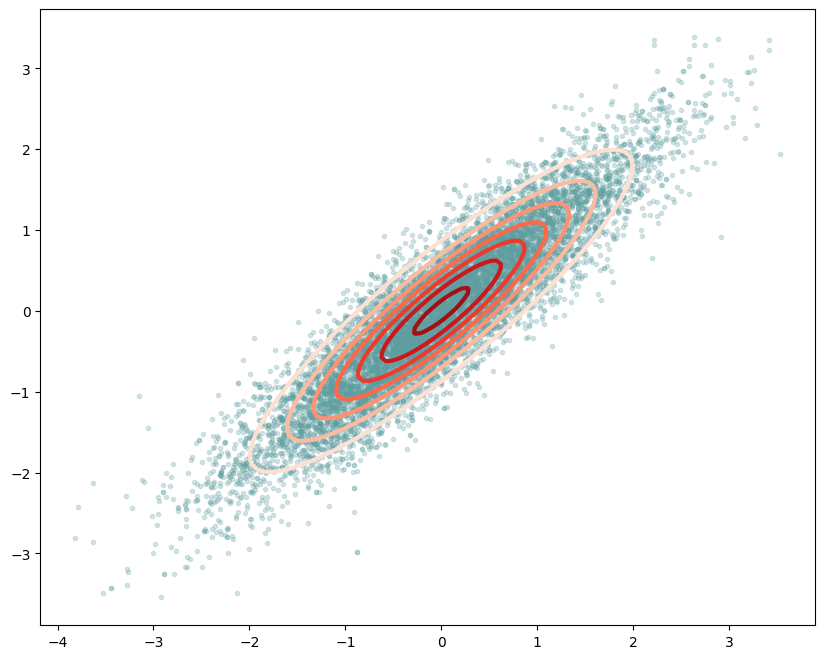

In [22]:
np.random.seed(seed=1)  # Fix the random seed for better reproducibility
x0 = np.random.normal(size=2)

R= 10000 #number of sample
L = 25 #number of simulation steps
eps = 0.375 #simulation step length
burn = int(R/10)

# HMC sampling
S, *_ = hmc.sample(x0, energy_func, energy_grad, R, L, eps, burn=burn, checkgrad=False, args=[covar])
# Plot the figure
plt.figure(figsize=fsz)
plt.plot(S[:, 0], S[:, 1], '.', ms=6, color='CadetBlue', alpha=0.25, zorder=0)
plt.contour(GX, GY, P.reshape((gsz, gsz)), cmap='Reds', linewidths=3, zorder=1)

# Step 5: Apply HMC to the Linear Regression Model

- `energy_func_lr(hps, x, y)`: where `hps` is a 2+9 dimension array, where the 1st dimension represents $\alpha$, and the 2nd represnets $\beta$. Thus, `hps[0]` should be the current $\alpha$, `hps[1]` the $\beta$ and `hps[2:]` represent the weights `w` for constant and 8 variables respectively. `x` and `y` is the x and y array of training data.

- `energy_grad_lr(hps, x, y)`: the gradient function returns an array containing the partial derivatives of the energy function. Should be the same shape for hps. 

- `R`: the number of samples
- `L`: number of simulation steps; for this simple case, 20 is easily enough
- `eps`: simulation step length; set by trial-and-error to give approx. 90% acceptance
- `burn`: simply set to `R/10`
- `checkgrad`: set to true to test the consistency of `energy_func` and `energy_grad`


In [23]:
def energy_func_lr(hps, X, y):
    w = hps[2:]
    a = hps[0]
    b = hps[1]
    y_pred = X@w
    residuals = y - y_pred
    N, M = X.shape
    g = np.exp(a)
    t = np.exp(b)
    neglgp = (0.5*g)*(w.T @ w) - M/2*a - N/2*b  + (0.5*t)*(residuals.T@residuals)
    return neglgp

def energy_grad_lr(hps, X, y):
    w = hps[2:]
    a = hps[0]
    b = hps[1]
    N, M = X.shape
    y_pred = X@w 
    residuals = y - y_pred
    g = np.exp(a)
    t = np.exp(b)
    grad_a = (w.T @ w)*(g)*0.5 - M/2
    grad_b = (residuals.T @ residuals)*(t/2) - N/2 
    grad_w =  g*w - t*X.T@y + t*X.T@X@w

    g = np.concatenate(([grad_a], [grad_b], grad_w))
    return g 

Calc.         Numeric       Delta         Acc.
-4.450266715139151
    -4.45027      -4.45027   5.935474e-07   7
131438.04090213962
      131438        131438   1.544447e-05  10
-9684.668009867892
    -9684.67      -9684.67   3.774914e-06  10
-2635.012657265179
    -2635.01      -2635.01   9.192186e-06   9
2811.130238114856
     2811.13       2811.13   1.314256e-06  10
-1824.4394304929301
    -1824.44      -1824.44  -1.164929e-06  10
3623.1940757716075
     3623.19       3623.19   9.534759e-06   9
-3755.581608857028
    -3755.58      -3755.58   1.591248e-05   9
-67.50097963958979
     -67.501       -67.501   1.324128e-05   7
-1041.8651363579556
    -1041.87      -1041.87   3.879139e-06   9
-227.87394118495286
    -227.874      -227.874   1.575478e-06   9
|----------|  0% accepted [ 18 secs to go ]
|#---------| 100% accepted [ 15 secs to go ]
|##--------| 100% accepted [ 14 secs to go ]
|###-------| 100% accepted [ 12 secs to go ]
|####------| 100% accepted [ 10 secs to go ]
|#####-----|

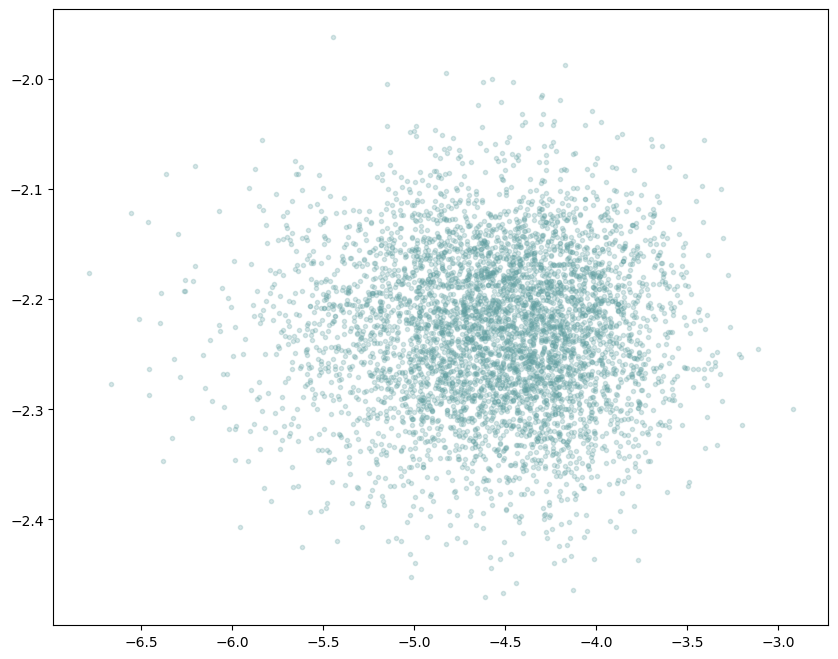

In [24]:
#Initialise alpha, beta and w
np.random.seed(1)
hps = np.full(11,0.1)

R= 5_000 #number of samples
L = 100 #number of simulation steps
eps = 0.00962 #simulation step length
burn = int(R/10)


# HMC sampling
S, *_ = hmc.sample(hps, energy_func_lr, energy_grad_lr, R, L, eps, burn=burn, checkgrad=True, args=[X_train, y_train])

# Plot the figure
plt.figure(figsize=fsz)
plt.plot(S[:, 0], S[:, 1], '.', ms=6, color='CadetBlue', alpha=0.25, zorder=0)

Print out the RMSE and plot figures for your report

In [25]:
#### **** YOUR CODE HERE **** ####
alpha_hmc, beta_hmc = np.mean(S[:, :2], axis=0)
w_hmc = np.mean(S[:, -9:], axis=0)
y_pred_train_hmc = X_train @ w_hmc
y_pred_test_hmc = X_test @ w_hmc

# Calculate MAE and RMSE for training set
mse_train = np.mean((y_pred_train_hmc - y_train)**2)
rmse_train = np.sqrt(mse_train)
mae_train = np.mean(np.abs(y_pred_train_hmc - y_train))

# Calculate MAE and RMSE for test set
mse_test = np.mean((y_pred_test_hmc - y_test)**2)
rmse_test = np.sqrt(mse_test)
mae_test = np.mean(np.abs(y_pred_test_hmc - y_test))

print("RMSE for training set: {:.4f}".format(rmse_train))
print("RMSE for test set: {:.4f}".format(rmse_test))
print("MAE for training set: {:.4f}".format(mae_train))
print("MAE for test set: {:.4f}".format(mae_test))

RMSE for training set: 3.0116
RMSE for test set: 2.8431
MAE for training set: 2.1293
MAE for test set: 2.0691


### Visualising the Distributions of Predictors

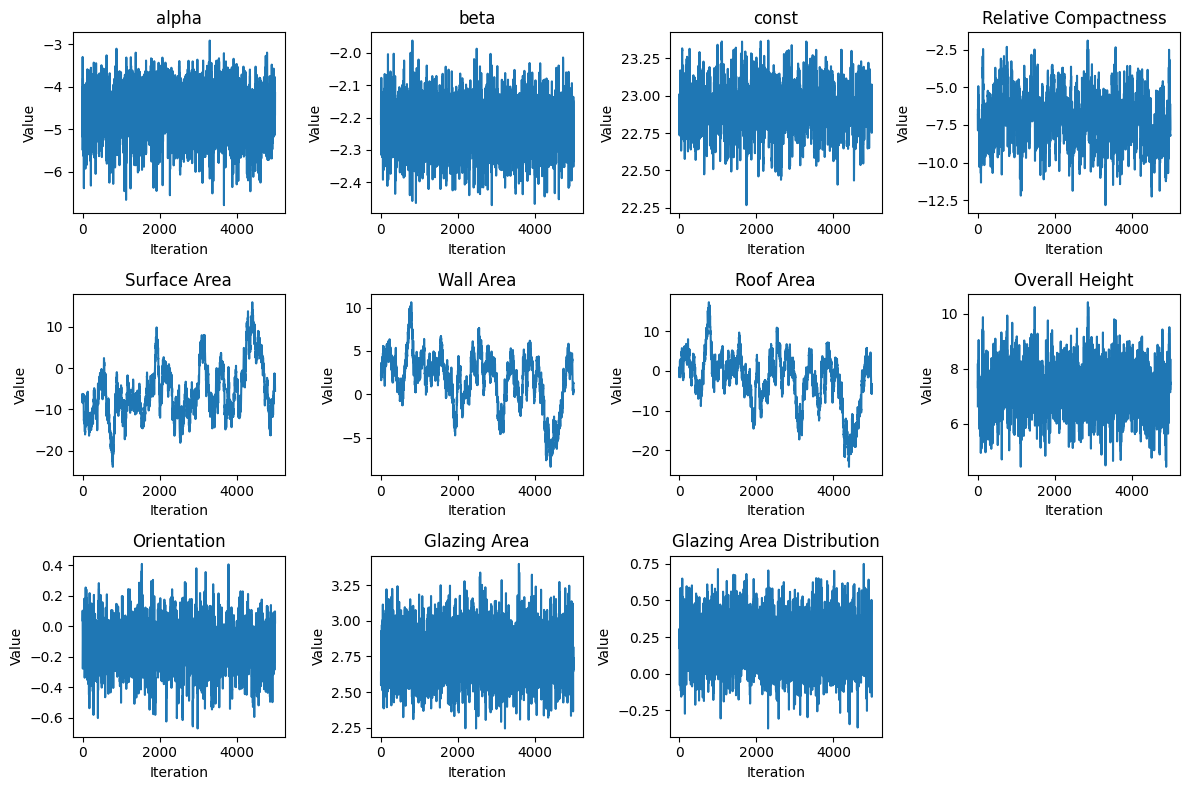

In [26]:
import matplotlib.pyplot as plt

# Create a 3x4 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))

# Flatten the axes array to make it easier to plot
axes = axes.flatten()
param_names = ['alpha', 'beta'] + list(X_train_df.columns)

# Loop over each parameter and plot its value against iteration number in a separate subplot
for i in range(S.shape[1]):
    ax = axes[i]
    ax.plot(S[:, i])
    ax.set_title(param_names[i])
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Value')

# Remove the unused subplots from the grid
for i in range(S.shape[1], len(axes)):
    fig.delaxes(axes[i])

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

Most probable a: 0.0105
Most probable B: 0.1076
Log_p given a & B: -1001.4877


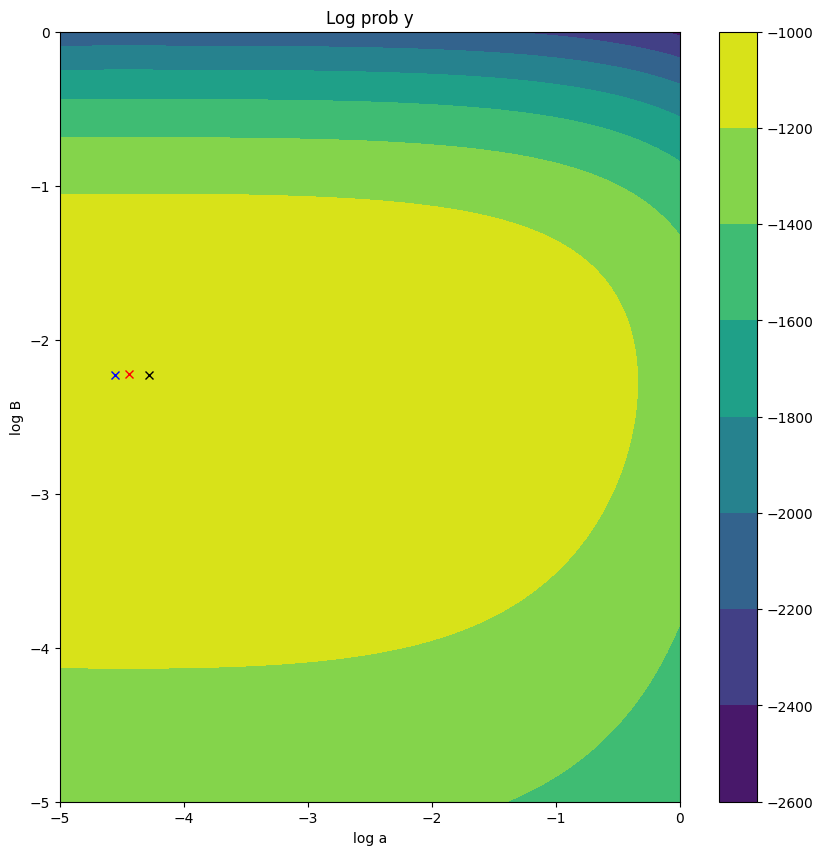

In [27]:
#Overlay contour on top of the original contour...
fig,ax=plt.subplots(1,1, figsize=(10,10))
cp = ax.contourf(log_a, log_B, log_prob_y)
fig.colorbar(cp)
ax.plot(np.log(max_a), np.log(max_B), 'rx', markersize=6)
ax.plot(np.log(exp_alpha), np.log(exp_beta), 'kx', markersize=6)
ax.plot(alpha_hmc, beta_hmc, 'x', markersize=6, markeredgecolor='blue')
ax.set_title('Log prob y')
ax.set_xlabel('log a')
ax.set_ylabel('log B')
plt.show


# Most probable alpha and beta 
max_log_prob = compute_log_marginal(X_train, y_train, np.exp(alpha_hmc), np.exp(beta_hmc))
print("Most probable a: {:.4f}".format(np.exp(alpha_hmc)))
print("Most probable B: {:.4f}".format(np.exp(beta_hmc)))
print("Log_p given a & B: {:.4f}".format(max_log_prob))

# Step 6: Apply HMC as a Classifier

Use a sigmoid function to generate a binary (high/low) classification.



In [28]:
def sigmoid_function(y):
    z = 1/(1+np.exp(-y))
    return z

def energy_func_classifier(hps, X, y):
    #Same process as before but apply sigmoid function to X to get y_post
    w = hps[2:]
    a = hps[0]
    b = hps[1]
    y_pred = X@w
    y_sig = sigmoid_function(y_pred)
    N, M = X.shape
    likelihood = y*np.log(y_sig) + (1-y)*np.log(1-y_sig)
    neglgp = -np.sum(likelihood) - (M/2)*np.log(a) + 0.5*(w@w.T*a)
    # log_likelihood = X@w @(y-one) - one.T@(np.log(1+np.exp(-X@w))) - (a*((w.T@w)/2))
    return neglgp 

def energy_grad_classifier(hps, X, y):
    w = hps[2:]
    a = hps[0]
    b = hps[1]
    N, M = X.shape
    y_pred = X@w
    y_sig = sigmoid_function(y_pred)
    dl_da = -M/(2*a) + (w@w.T)/2
    dl_db = 0
    dl_dw = -X.T@(y - y_sig ) + (a*w)

    g = np.concatenate(([dl_da], [dl_db], dl_dw))
    return g


Calc.         Numeric       Delta         Acc.
-44.95500002121844
     -44.955       -44.955  -2.121844e-08  10
           0             0   0.000000e+00  16
7.512933166253788
     7.51293       7.51293   1.783047e-09  10
-148.9687535070061
    -148.969      -148.969   2.586273e-08  10
155.2526284456235
     155.253       155.253   1.725039e-08  10
-44.399343380518985
    -44.3993      -44.3993   4.261391e-08  10
173.55851781530873
     173.559       173.559  -1.166222e-08  11
-178.00998352868191
     -178.01       -178.01   1.673112e-08  11
3.010191619523539
     3.01019       3.01019   4.533861e-09   9
-4.117442443885011
    -4.11744      -4.11744  -7.818521e-09   9
0.14092387345954194
    0.140924      0.140924   6.163727e-08   7
|----------|  0% accepted [ 14 secs to go ]
|#---------| 97% accepted [ 12 secs to go ]


/var/folders/r4/p_tcw0jx4w998smqly14xnbh0000gn/T/ipykernel_6783/2886707079.py:25: RuntimeWarning: overflow encountered in matmul
  dl_da = -M/(2*a) + (w@w.T)/2
/var/folders/r4/p_tcw0jx4w998smqly14xnbh0000gn/T/ipykernel_6783/2886707079.py:27: RuntimeWarning: overflow encountered in multiply
  dl_dw = -X.T@(y - y_sig ) + (a*w)
/var/folders/r4/p_tcw0jx4w998smqly14xnbh0000gn/T/ipykernel_6783/2886707079.py:23: RuntimeWarning: invalid value encountered in matmul
  y_pred = X@w
/var/folders/r4/p_tcw0jx4w998smqly14xnbh0000gn/T/ipykernel_6783/2886707079.py:14: RuntimeWarning: overflow encountered in matmul
  neglgp = -np.sum(likelihood) - (M/2)*np.log(a) + 0.5*(w@w.T*a)


|##--------| 95% accepted [ 11 secs to go ]


/var/folders/r4/p_tcw0jx4w998smqly14xnbh0000gn/T/ipykernel_6783/2886707079.py:10: RuntimeWarning: invalid value encountered in matmul
  y_pred = X@w
/Users/matthewhilton/repos/bayesian-linear-regression/hmc_Lab.py:123: RuntimeWarning: overflow encountered in square
  proposed_K = np.sum(p**2) / 2


|###-------| 91% accepted [ 9 secs to go ]
|####------| 93% accepted [ 8 secs to go ]
|#####-----| 93% accepted [ 7 secs to go ]
|######----| 94% accepted [ 6 secs to go ]
|#######---| 94% accepted [ 4 secs to go ]
|########--| 94% accepted [ 3 secs to go ]
|#########-| 95% accepted [ 1 secs to go ]
|##########| 95% accepted [ 0 secs to go ]
HMC: R=5000 / L=100 / eps=0.01 / Accept=95.0%


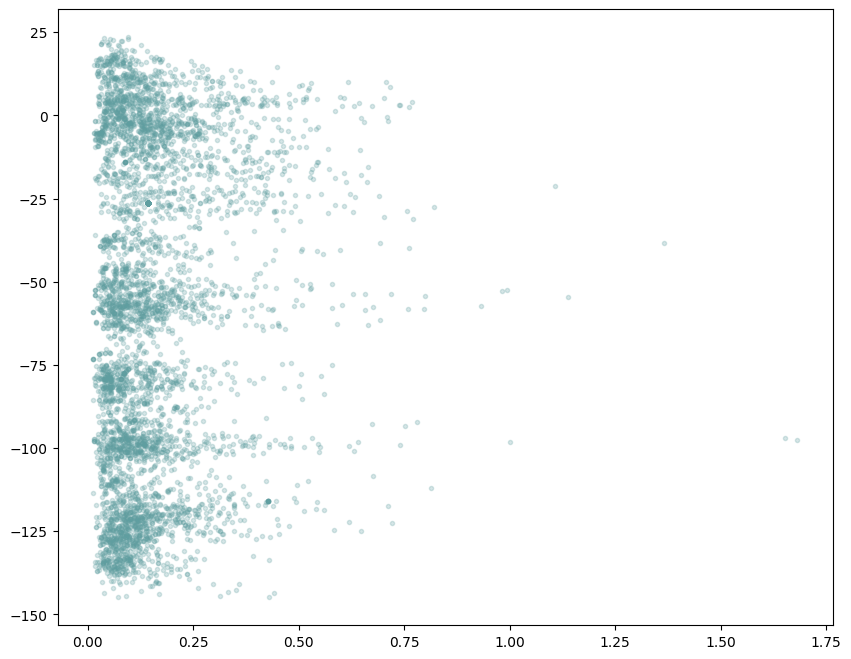

In [29]:
#Initialise alpha, beta and w
np.random.seed(1)
hps = np.full(11,0.1)
y_train_binary = np.where(y_train >= 23, int(1), int(0))
y_test_binary = np.where(y_test >= 23, int(1), int(0))


R= 5_000 #number of samples
L = 100 #number of simulation steps
eps = 0.01 #simulation step length
burn = int(R/10)

# HMC sampling
S_, *_ = hmc.sample(hps, energy_func_classifier, energy_grad_classifier, R, L, eps, burn=burn, checkgrad=True, args=[X_train, y_train_binary])

# Plot the figure
plt.figure(figsize=fsz)
plt.plot(S_[:, 0], S_[:, 1], '.', ms=6, color='CadetBlue', alpha=0.25, zorder=0)

In [30]:
threshold = 0.5

#train prediction
y_train_pred = sigmoid_function((X_train @ S_[:,2:].T).mean(axis = 1))
y_train_pred = np.where(y_train_pred >= threshold, 1, 0)
train_misclassified = np.sum(y_train_pred != y_train_binary)

# calculate the train misclassification error
train_error = train_misclassified / len(y_train)
print("Train Misclassified:", train_misclassified)
print("Train Misclassification error: {:.4f} %".format(train_error*100))

#test prediction
y_test_pred = sigmoid_function((X_test @ S_[:,2:].T).mean(axis = 1))
y_test_pred = np.where(y_test_pred >= threshold, 1, 0)
test_misclassified = np.sum(y_test_pred != y_test_binary)

# calculate the train misclassification error
test_error = test_misclassified / len(y_test)
print("Test Misclassified:", test_misclassified)
print("Test Misclassification error: {:.4f} %".format(test_error*100))

Train Misclassified: 5
Train Misclassification error: 1.3021 %
Test Misclassified: 4
Test Misclassification error: 1.0417 %


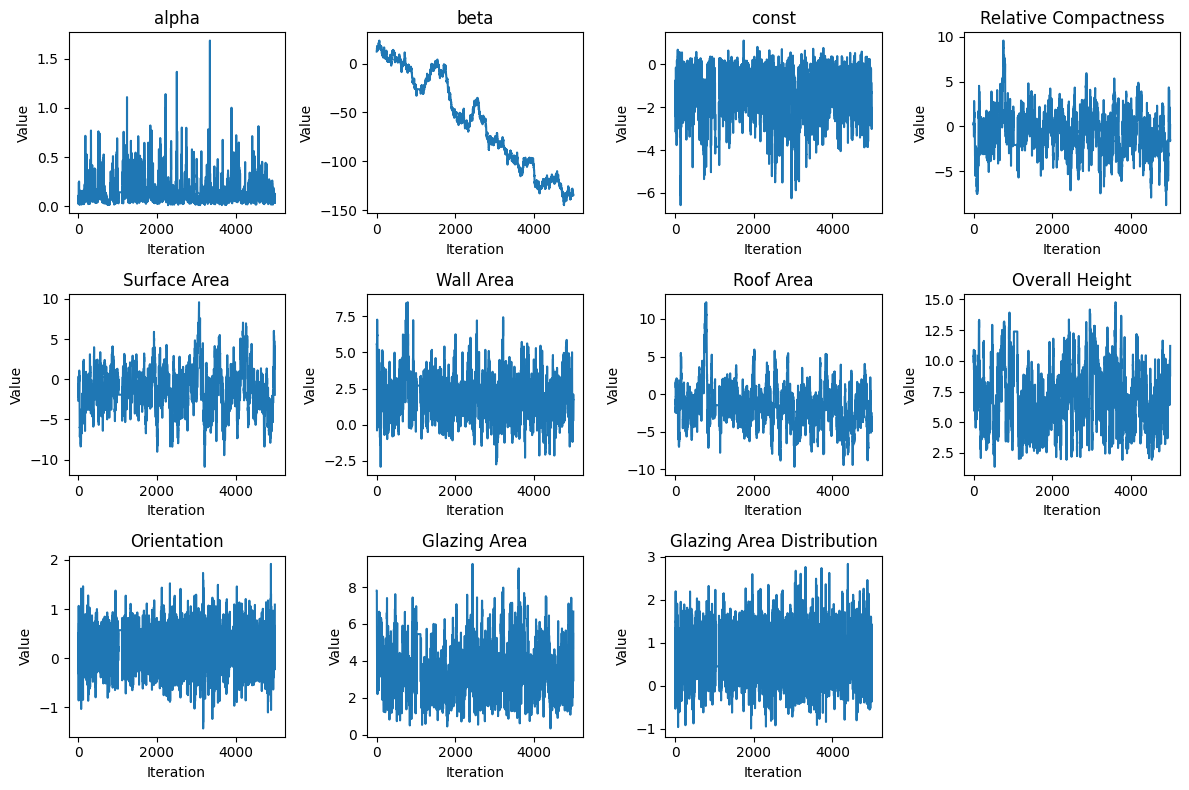

In [31]:
import matplotlib.pyplot as plt

# Create a 3x4 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))

# Flatten the axes array to make it easier to plot
axes = axes.flatten()
param_names = ['alpha', 'beta'] + list(X_train_df.columns)

# Loop over each parameter and plot its value against iteration number in a separate subplot
for i in range(S_.shape[1]):
    ax = axes[i]
    ax.plot(S_[:, i])
    ax.set_title(param_names[i])
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Value')

# Remove the unused subplots from the grid
for i in range(S_.shape[1], len(axes)):
    fig.delaxes(axes[i])

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()